<a href="https://colab.research.google.com/github/castillosebastian/research_tools/blob/master/XGBoost_for_Time_Series_Forecasting_%5BBETA%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost for Time Series Forecasting

This notebook is inspired by [How to Use XGBoost for Time Series Forecasting
](https://machinelearningmastery.com/xgboost-for-time-series-forecasting/)

author : [Junior N.](https://twitter.com/nprime496)

![](https://s32519.pcdn.co/wp-content/uploads/2019/12/measuring-forecast-accuracy-banner-2272px.png)

# Introduction


This notebook is done as an experimentation/implementation of this [blog](https://machinelearningmastery.com/xgboost-for-time-series-forecasting/). Although a code base is available in the original article, this notebook come with some modifications:
* some code restructuration to help modification
* multivariate input handling
* hyperparameter search
* multiple metrics handling (rmse,mae, etc)
* basic feature engineering
* model explanation (Actually just showing the most predictive features)

All of these leading to **a better performance compared to the original post**.
I hope that you find it interresting.

[XGBoost](https://xgboost.readthedocs.io/en/stable/) is an efficient implementation of gradient boosting for classification and regression problems.

It is both fast and efficient, performing well, if not the best, on a wide range of predictive modeling tasks and is a favorite among data science competition winners, such as those on Kaggle.

XGBoost can also be used for time series forecasting, although it requires that the time series dataset be transformed into a supervised learning problem first.

In fact, Time series data can be phrased as supervised learning. Given a sequence of numbers for a time series dataset, we can restructure the data to look like a supervised learning problem. We can do this by using previous time steps as input variables and use the next time step as the output variable.


Don't worry if you didn't understand everything[.](https://miro.medium.com/max/1400/1*yIPIuNIn6ar7MvQnNqlWlQ.jpeg) It will be clear I hope in a moment.


# Setup


In [ ]:
!nvidia-smi

## Installations & Imports

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# xgboost
import xgboost
print("xgboost", xgboost.__version__)

xgboost 0.90


In [ ]:
!wget  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv

--2022-07-30 17:15:29--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6220 (6.1K) [text/plain]
Saving to: ‘daily-total-female-births.csv.1’

daily-total-female- 100%[===================>]   6.07K  --.-KB/s    in 0s      

2022-07-30 17:15:29 (51.9 MB/s) - ‘daily-total-female-births.csv.1’ saved [6220/6220]



In [ ]:
from xgboost import XGBRegressor

In [ ]:
import numpy as np

In [ ]:
import pandas as pd

In [ ]:
import optuna

In [ ]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error,mean_squared_error
from xgboost import XGBRegressor
from matplotlib import pyplot 

# About Dataset


## Context
A time series dataset depicting the total number of female births recording in California, USA during the year of 1959.

This is a very basic time series dataset, with only the date ("dd/mm/yyyy" format), and the number of births. There are 365 records in total.

We will try to forecast number of births at a date given the past observations.

In [ ]:
# load the dataset
series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0)
series.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [ ]:
series.reset_index(inplace=True)
series['Date'] = pd.to_datetime(series['Date'])
values = series.values

# EDA

Take a look at the the number of births evolution.

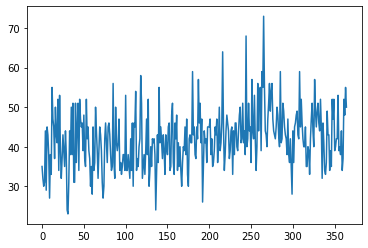

In [ ]:
# load and plot the time series dataset
from pandas import read_csv
from matplotlib import pyplot
# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
values = series.values
# plot dataset
pyplot.plot(values)
pyplot.show()


# Preprocessing

Here we preprocess the dataset (normalizing data if necessary, removing useless columns,...)

## Cleaning

In [ ]:
series.reset_index(inplace=True)
series['Date'] = pd.to_datetime(series['Date'])
series.head()

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


We add a new feature which is [moving average](https://en.wikipedia.org/wiki/Moving_average) given some window.

We also added weekend markup but it doesn't seem to help so it was removed.

In [ ]:
def feature_engineering(df,roll=20):
  df['day_sin'] = df['Date'].apply(lambda x:np.sin(x.weekday()))
  df['mean_rolling']  = df['Births'].rolling(window=roll,min_periods=1).mean()
  # df['weekend'] = df['Date'].apply(lambda x:int(x.weekday()>=5))
  df = df.drop('Date', axis=1)
  return df

In [ ]:
data = feature_engineering(series)
#data = series.reset_index(drop=True).drop('Date', axis=1)
data.head(5)

,Births,day_sin,mean_rolling,weekend
0,35,0.141120,35.000000,0
1,32,-0.756802,33.500000,0
2,30,-0.958924,32.333333,1
3,31,-0.279415,32.000000,1
4,44,0.000000,34.400000,0


In [ ]:
def generate_supervised(data,n_in,roll=20):
  df = feature_engineering(data,roll)
  X=[]
  y=[]
  for i in range(0,len(df)-n_in):
    X.append(np.concatenate(df.values[i:n_in+i],axis=-1))
    y.append(df.values[n_in+i][0])
  return X,y

## Splitting Scheme

We define how splitting will be done.

XGBoost can be used for time series forecasting, although it requires that the time series dataset be transformed into a supervised learning problem first. It also requires the use of a specialized technique for evaluating the model called walk-forward validation, **as evaluating the model using k-fold cross validation would result in optimistically biased results.**

For example, it would not be valid to fit the model on data from the future and have it predict the past. The model must be trained on the past and predict the future. This means that methods that randomize the dataset during evaluation, like k-fold cross-validation, cannot be used. Instead, we must use a technique called walk-forward validation.


In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# Model Selection

In walk-forward validation, the dataset is first split into train and test sets by selecting a cut point, e.g. all data except the last 12 days is used for training and the last 12 days is used for testing.

If we are interested in making a one-step forecast, e.g. one month, then we can evaluate the model by training on the training dataset and predicting the first step in the test dataset. We can then add the real observation from the test set to the training dataset, refit the model, then have the model predict the second step in the test dataset.

Repeating this process for the entire test dataset will give a one-step prediction for the entire test dataset from which an error measure can be calculated to evaluate the skill of the model.



We will use [optuna](https://optuna.org/) for hyperparameter search. Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. 


In [ ]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(model, train, X_test):
  # transform list into array

  X_train,y_train = list(zip(*train))
  train = asarray(X_train)
  # split into input and output columns
  trainX, trainy = X_train, y_train
  testX = X_test
  # fit model
  model.fit(list(trainX), list(trainy))

  # make a one-step prediction
  yhat = model.predict(asarray([testX]))
  return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(model, X_train,y_train,X_test,y_test, n_test):
  predictions = list()
 
  # seed history with training dataset
  history = [(x,y) for x,y in zip(X_train,y_train)]
  # step over each time-step in the test set
  for i in range(len(X_test)):
    # split test row into input and output columns
    testX, testy = X_test[i], y_test[i]
    # fit model on history and make a prediction
    yhat = xgboost_forecast(model,history, testX )
    #return yhat
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append((testX,testy))
    # summarize progress
    #print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
  # estimate prediction error
  errors = {}
  errors['mae'] = mean_absolute_error(y_test, predictions)
  errors['rmse'] = np.sqrt(mean_squared_error(y_test,predictions))
  return errors, y_test, predictions

In [ ]:
def objective(trial):
    # Invoke suggest methods of a Trial object to generate hyperparameters.
    # Parameters are "sugested" by optuna at each trial using stochastic techniques
    param = {
        #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 5.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 5.0),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_categorical('n_estimators', [100,300,500,700,900,1000]),
        'max_depth': trial.suggest_categorical('max_depth', [3,5,7,9]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'n_in':trial.suggest_categorical('n_in', [2,5,7,10,15]),
        'roll':trial.suggest_categorical('roll', [2,5,10,15,20,30])
    }

    X,y = generate_supervised(series,n_in=param['n_in'],roll = param['roll'])
    # split dataset
    X_train, X_test = train_test_split(X, 20)
    y_train, y_test = train_test_split(y, 20)


    model = XGBRegressor(objective='reg:squarederror', **param)

    errors, y, yhat = walk_forward_validation(model,X_train,y_train,X_test,y_test,20) 
    return errors['mae']

In [ ]:
# This takes ~15min on CPU
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-07-30 17:53:20,829] A new study created in memory with name: no-name-455bbdd2-0bc4-4583-a576-2d771a652b0a
[I 2022-07-30 17:53:36,829] Trial 0 finished with value: 5.940635299682617 and parameters: {'lambda': 2.1374950029488358, 'alpha': 4.81106835941145, 'learning_rate': 0.014, 'n_estimators': 900, 'max_depth': 7, 'random_state': 2020, 'n_in': 5, 'roll': 15}. Best is trial 0 with value: 5.940635299682617.
[I 2022-07-30 17:53:38,919] Trial 1 finished with value: 12.701558780670165 and parameters: {'lambda': 0.3073857362202316, 'alpha': 0.4395121914993376, 'learning_rate': 0.014, 'n_estimators': 100, 'max_depth': 9, 'random_state': 2020, 'n_in': 10, 'roll': 10}. Best is trial 0 with value: 5.940635299682617.
[I 2022-07-30 17:53:48,990] Trial 2 finished with value: 6.105617332458496 and parameters: {'lambda': 0.006655530340644458, 'alpha': 0.001233863518896599, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 9, 'random_state': 2020, 'n_in': 5, 'roll': 2}. Best is trial 0 

Number of finished trials: 50
Best trial: {'lambda': 0.0013368807529774332, 'alpha': 0.0015670687634701816, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 3, 'random_state': 2020, 'n_in': 2, 'roll': 20}


# Evaluation

## Final Model

We run the entire pipeline using the results we obtained from optuna.

In [ ]:
# study.best_trial.params

{'alpha': 0.0015670687634701816,
 'lambda': 0.0013368807529774332,
 'learning_rate': 0.02,
 'max_depth': 3,
 'n_estimators': 1000,
 'n_in': 2,
 'random_state': 2020,
 'roll': 20}

In [ ]:
# The results I obtained after 50 trials
# best_params = study.best_trial.params
best_params =  {'alpha': 0.0015670687634701816,
 'lambda': 0.0013368807529774332,
 'learning_rate': 0.02,
 'max_depth': 3,
 'n_estimators': 1000,
 'n_in': 2,
 'random_state': 2020,
 'roll': 20}

In [ ]:
n_in = best_params['n_in']
roll = best_params['roll']

X,y = generate_supervised(series,n_in=n_in,roll=roll)
# split dataset
X_train, X_test = train_test_split(X, 20)
y_train, y_test = train_test_split(y, 20)


In [ ]:
model = XGBRegressor(objective='reg:squarederror', **best_params)

errors, y, yhat = walk_forward_validation(model,X_train,y_train,X_test,y_test,20)

## Results

Let see the results !

Errors: {'mae': 4.703444099426269, 'rmse': 5.969725553871381}


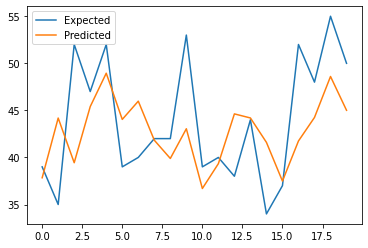

In [ ]:
print('Errors: {0}'.format(errors))
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()

pyplot.show()

🎆🎇🎈🎉 🎊 We achieve **4.70** on MAE compared to **5.95** on original post!!

# Explanation (XAI)

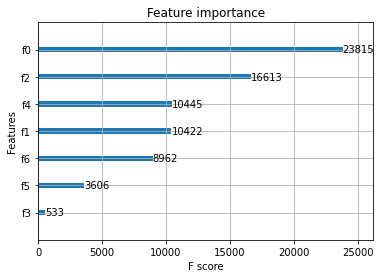

In [ ]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(model)
pyplot.show()

| fi     | fi+1    | fi+2         | fi+3    |
|--------|---------|--------------|---------|
| births | day_sin | rolling_mean | weekend |

We can see that :
* features are indeed the past observations (f0,f4)
* but also we see that f2 (rolling mean) has a great impact! That's interesting because we tried the setup with more input days but it didn't work as great, we can ask ourselves **Why is rolling mean more predictive that actual previous vaues?**

# Conclusion

In this notebook, you discovered how to develop an XGBoost model for time series forecasting, make hyperparameter search using optuna and look at model decision's features. We can see a boost in precision by adding just one feature, even though the dataset is quite simple, there's some room for improvement. I strongly encourage you to try (and maybe share your results).

Specifically, you learned:

XGBoost is an implementation of the gradient boosting ensemble algorithm for classification and regression.
Time series datasets can be transformed into supervised learning using a sliding-window representation.
How to fit, evaluate, and make predictions with an XGBoost model for time series forecasting.


# References

* [How to Use XGBoost for Time Series Forecasting
](https://machinelearningmastery.com/xgboost-for-time-series-forecasting/)
* [Daily total female births in California, 1959
](https://www.kaggle.com/datasets/dougcresswell/daily-total-female-births-in-california-1959)
* [XGBoost & Catboost Using Optuna 🏄🏻‍♂️](https://www.kaggle.com/code/hamzaghanmi/xgboost-catboost-using-optuna?scriptVersionId=94510532)